In [1]:
import numpy as np
import pandas as pd
import warnings
import ast
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('Synthetic_Loans_Data1.csv')
val_df = pd.read_csv('Synthetic_Loans_Data_val.csv')

In [3]:
train_df['Eligibility'].value_counts()

Eligibility
[]                 78994
['504']            11142
['7(a)', '504']     6054
['Express']         3509
['8(a)']             301
Name: count, dtype: int64

In [4]:
drop_cols = ['Applicant ID', 'Location'] 


train_df = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns], errors='ignore')
val_df = val_df.drop(columns=[col for col in drop_cols if col in val_df.columns], errors='ignore')

In [5]:
bool_columns = train_df.select_dtypes(include=['bool']).columns.tolist()
train_df[bool_columns] = train_df[bool_columns].astype(int)
val_df[bool_columns] = val_df[bool_columns].astype(int)

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [7]:
categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
numerical_features = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [8]:
categorical_features = [col for col in categorical_features if col != 'Eligibility']
numerical_features = [col for col in numerical_features if col != 'Eligibility']

numerical_features += bool_columns

In [9]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [10]:
def is_eligible_504(x):
    try:
        return 1 if '504' in ast.literal_eval(x) else 0
    except:
        return 0

In [11]:
train_df['eligible_504'] = train_df['Eligibility'].apply(is_eligible_504)

In [12]:
val_df['eligible_504'] = np.random.choice([0, 1], size=len(val_df), p=[0.6, 0.4])

In [13]:
train_df.drop(columns=['Eligibility'], inplace=True)

In [14]:
X_train, y_train = train_df.drop(columns=['eligible_504']), train_df['eligible_504']
X_test, y_test = val_df.drop(columns=['eligible_504']), val_df['eligible_504']

In [15]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [16]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
y_pred = model.predict(X_test)
y_pred = y_pred.astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.83      0.70      6046
           1       0.41      0.18      0.25      3954

    accuracy                           0.57     10000
   macro avg       0.51      0.50      0.47     10000
weighted avg       0.53      0.57      0.52     10000



In [18]:
feature_names = preprocessor.get_feature_names_out()
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

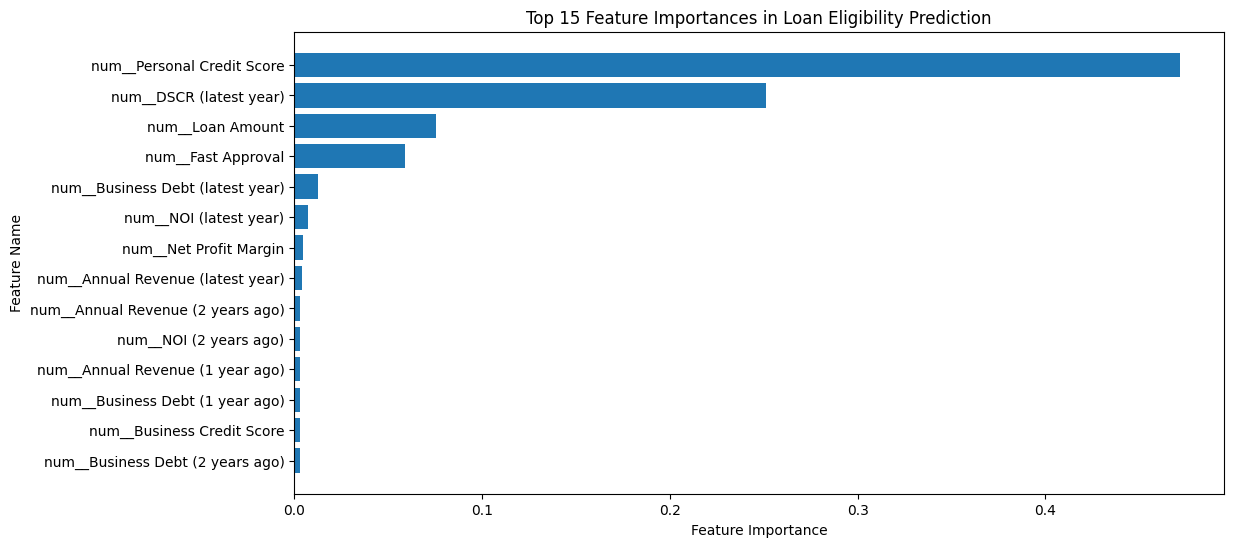

In [19]:
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'][:15], importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 15 Feature Importances in Loan Eligibility Prediction')
plt.show()

In [20]:
low_importance_features = importance_df[importance_df['Importance'] < 0.01]['Feature'].tolist()
print("Low-importance features to consider dropping:", low_importance_features)

Low-importance features to consider dropping: ['num__NOI (latest year)', 'num__Net Profit Margin', 'num__Annual Revenue (latest year)', 'num__Annual Revenue (2 years ago)', 'num__NOI (2 years ago)', 'num__Annual Revenue (1 year ago)', 'num__Business Debt (1 year ago)', 'num__Business Credit Score', 'num__Business Debt (2 years ago)', 'num__NOI (1 year ago)', 'num__DSCR (1 year ago)', 'num__NAICS', 'num__DSCR (2 years ago)', 'num__Industry Experience', 'num__Managerial Experience', 'num__Years in Business', 'num__Business Ownership (2)', 'num__Business Ownership (1)', 'num__For Profit', 'cat__Business Structure_Nonprofit Organization', 'num__Collateral Availability', 'num__For Profit', 'num__Business Ownership (3)', 'num__Collateral Availability', 'num__Real Estate Acquisition or Improvement', 'cat__Business Structure_LLC', 'num__Equipment Purchase or Leasing', 'num__Licensing or Permits', 'num__Refinancing Existing Debt', 'num__Licensing or Permits', 'num__Equipment Purchase or Leasing

<Axes: xlabel='eligible_504'>

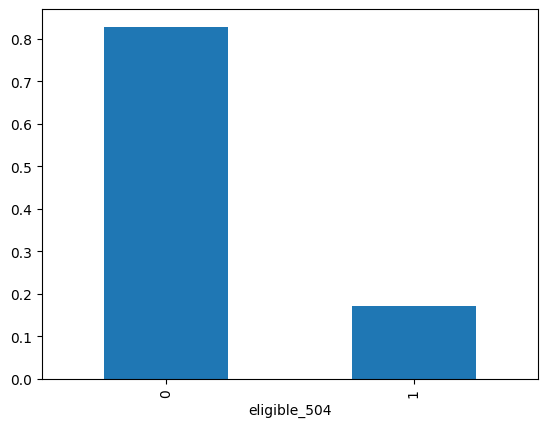

In [21]:
train_df['eligible_504'].value_counts(normalize=True).plot(kind='bar')

<Axes: xlabel='eligible_504'>

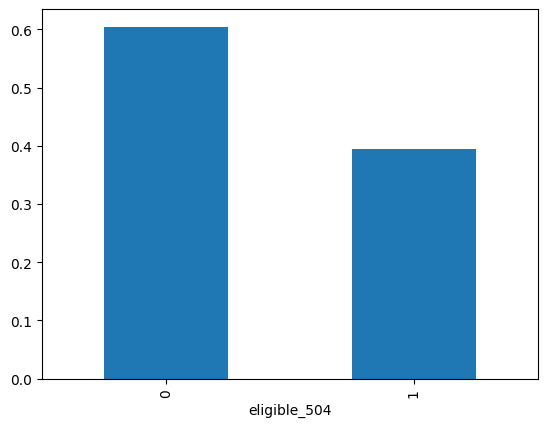

In [22]:
val_df['eligible_504'].value_counts(normalize=True).plot(kind='bar')

In [23]:
from sklearn.utils import resample

In [24]:
df_majority = train_df[train_df['eligible_504'] == 0]
df_minority = train_df[train_df['eligible_504'] == 1]

df_majority_downsampled = resample(
    df_majority,
    replace=False,                     
    n_samples=len(df_minority),        
    random_state=42                     
)

In [25]:
df_undersampled = pd.concat([df_majority_downsampled, df_minority])

df_undersampled = df_undersampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [26]:
X_train_u = pd.get_dummies(df_undersampled.drop(columns=['eligible_504']), drop_first=True)
y_train_u = df_undersampled['eligible_504']

X_val = pd.get_dummies(val_df.drop(columns=['eligible_504']), drop_first=True)
y_val = val_df['eligible_504']

X_train_u, X_val = X_train_u.align(X_val, join='left', axis=1, fill_value=0)

In [27]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [28]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_u, y_train_u)

xgb_preds = xgb_model.predict(X_val)

print("XGBoost Results:\n")
print(classification_report(y_val, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, xgb_preds))

XGBoost Results:

              precision    recall  f1-score   support

           0       0.61      0.83      0.70      6046
           1       0.41      0.18      0.25      3954

    accuracy                           0.57     10000
   macro avg       0.51      0.50      0.47     10000
weighted avg       0.53      0.57      0.52     10000

Confusion Matrix:
 [[5005 1041]
 [3242  712]]


In [29]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_u, y_train_u)

lgb_preds = lgb_model.predict(X_val)

print("LightGBM Results:\n")
print(classification_report(y_val, lgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, lgb_preds))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17196, number of negative: 17196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4019
[LightGBM] [Info] Number of data points in the train set: 34392, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Results:

              precision    recall  f1-score   support

           0       0.61      0.83      0.70      6046
           1       0.41      0.18      0.25      3954

    accuracy                           0.57     10000
   macro avg       0.51      0

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

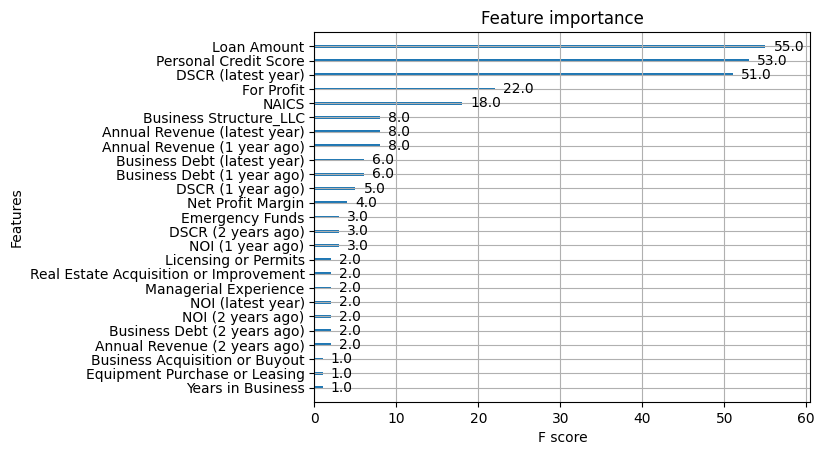

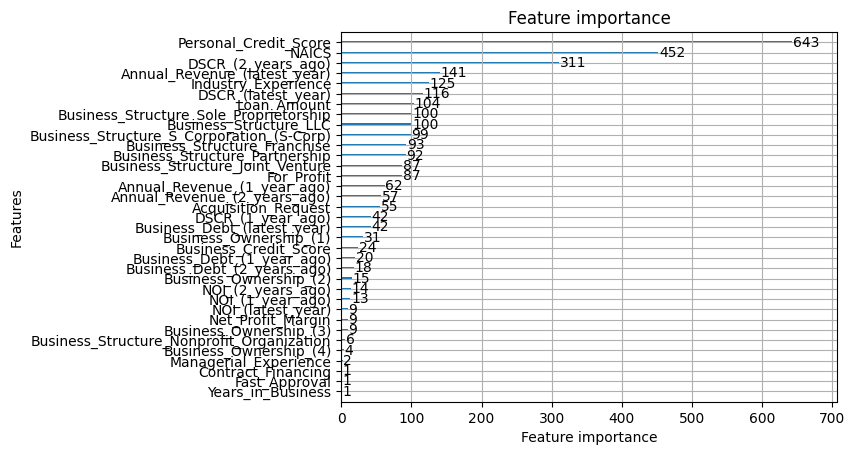

In [30]:
xgb.plot_importance(xgb_model)
lgb.plot_importance(lgb_model)

In [31]:
import shap
import matplotlib.pyplot as plt

In [32]:
# Get transformed feature names from ColumnTransformer
#feature_names = preprocessor.get_feature_names_out()
#explainer_xgb = shap.Explainer(xgb_model, X_train_u)
#shap_values_xgb = explainer_xgb(X_val)
#explainer_xgb
# shap.summary_plot(shap_values_xgb, pd.DataFrame(X_val_prep, columns=feature_names))

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [34]:
from sklearn.preprocessing import StandardScaler

numeric_cols = [col for col in X_train_u.columns if col in numerical_features]

scaler = StandardScaler()
X_train_u_scaled = X_train_u.copy()
X_val_scaled = X_val.copy()

X_train_u_scaled[numeric_cols] = scaler.fit_transform(X_train_u[numeric_cols])
X_val_scaled[numeric_cols] = scaler.transform(X_val[numeric_cols])

X_train_u_scaled = X_train_u_scaled.astype('float32')
X_val_scaled = X_val_scaled.astype('float32')
y_train_u = y_train_u.astype('float32')
y_val = y_val.astype('float32')

In [35]:
lr = 0.0005
epoch = 20

early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=3,           
    restore_best_weights=True 
)

input_shape = X_train_u_scaled.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    BatchNormalization(),
    Dropout(0.2),  
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_u_scaled, y_train_u,
                    validation_data=(X_val_scaled, y_val),
                    epochs=epoch,
                    batch_size=128,
                    verbose=1,
                    callbacks=[early_stopping]) 

test_loss, test_acc = model.evaluate(X_val_scaled, y_val)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/20


2025-04-18 02:18:22.474554: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-18 02:18:22.474582: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-04-18 02:18:22.474586: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-04-18 02:18:22.474612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-18 02:18:22.474619: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-04-18 02:18:22.867200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7714 - loss: 0.4993 - val_accuracy: 0.5512 - val_loss: 1.8298
Epoch 2/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8885 - loss: 0.2636 - val_accuracy: 0.5520 - val_loss: 2.0921
Epoch 3/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8997 - loss: 0.2465 - val_accuracy: 0.5490 - val_loss: 2.3072
Epoch 4/20
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8986 - loss: 0.2558 - val_accuracy: 0.5479 - val_loss: 2.4840
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5544 - loss: 1.8239
Test Accuracy: 0.5512


In [39]:
# Predict probabilities (use [:,1] if you want just the "positive class" prob)
pred_nn = model.predict(X_val_scaled).flatten()
pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
pred_lgb = lgb_model.predict_proba(X_val)[:, 1]

meta_X = np.column_stack((pred_nn, pred_xgb, pred_lgb))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [40]:
from sklearn.linear_model import LogisticRegression

meta_model = LogisticRegression()
meta_model.fit(meta_X, y_val)  

LogisticRegression()

In [41]:
meta_preds = meta_model.predict(meta_X)

from sklearn.metrics import accuracy_score, roc_auc_score
print("Meta-model Accuracy:", accuracy_score(y_val, meta_preds))
print("Meta-model ROC AUC:", roc_auc_score(y_val, meta_preds))

Meta-model Accuracy: 0.6046
Meta-model ROC AUC: 0.5


In [45]:
model.save("nn_504_model.keras")

In [44]:
import joblib
joblib.dump(xgb_model, "xgb_model.pkl")
joblib.dump(lgb_model, "lgb_model.pkl")
joblib.dump(meta_model, "meta_model.pkl")

['meta_model.pkl']

In [47]:
feature_names = list(X_train_u.columns)
feature_names

['NAICS',
 'Business Ownership (1)',
 'Business Ownership (2)',
 'Business Ownership (3)',
 'Business Ownership (4)',
 'Business Ownership (5)',
 'Personal Credit Score',
 'Business Credit Score',
 'Annual Revenue (2 years ago)',
 'Annual Revenue (1 year ago)',
 'Annual Revenue (latest year)',
 'Net Profit Margin',
 'Business Debt (2 years ago)',
 'Business Debt (1 year ago)',
 'Business Debt (latest year)',
 'NOI (2 years ago)',
 'NOI (1 year ago)',
 'NOI (latest year)',
 'DSCR (2 years ago)',
 'DSCR (1 year ago)',
 'DSCR (latest year)',
 'Industry Experience',
 'Managerial Experience',
 'Years in Business',
 'Collateral Availability',
 'Loan Amount',
 'Fast Approval',
 'For Profit',
 'Acquisition Request',
 'Working Capital',
 'Business Expansion',
 'Equipment Purchase or Leasing',
 'Inventory Purchase',
 'Real Estate Acquisition or Improvement',
 'Business Acquisition or Buyout',
 'Refinancing Existing Debt',
 'Emergency Funds',
 'Franchise Financing',
 'Contract Financing',
 'Licen

In [48]:
joblib.dump(feature_names, "feature_names.pkl")

['feature_names.pkl']

In [49]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [50]:
base_feature_names = list(df_undersampled.columns)
base_feature_names

['Business Structure',
 'Country',
 'NAICS',
 'Business Ownership (1)',
 'Business Ownership (2)',
 'Business Ownership (3)',
 'Business Ownership (4)',
 'Business Ownership (5)',
 'Personal Credit Score',
 'Business Credit Score',
 'Annual Revenue (2 years ago)',
 'Annual Revenue (1 year ago)',
 'Annual Revenue (latest year)',
 'Net Profit Margin',
 'Business Debt (2 years ago)',
 'Business Debt (1 year ago)',
 'Business Debt (latest year)',
 'NOI (2 years ago)',
 'NOI (1 year ago)',
 'NOI (latest year)',
 'DSCR (2 years ago)',
 'DSCR (1 year ago)',
 'DSCR (latest year)',
 'Industry Experience',
 'Managerial Experience',
 'Years in Business',
 'Collateral Availability',
 'Loan Amount',
 'Fast Approval',
 'For Profit',
 'Acquisition Request',
 'Working Capital',
 'Business Expansion',
 'Equipment Purchase or Leasing',
 'Inventory Purchase',
 'Real Estate Acquisition or Improvement',
 'Business Acquisition or Buyout',
 'Refinancing Existing Debt',
 'Emergency Funds',
 'Franchise Financi